# 🛰️ Projeto MOTTU: Machine Learning com Beacons via MQTT

### 👨‍👩‍👦‍👦 Integrantes

Arthur Ramos dos Santos - RM558798

Robet Daniel da Silva Coimbra - RM555881

Felipe Melo de Souza - RM556099

Turma: 2TDSPW

# 📦 Importação das bibliotecas necessárias

In [1]:
# Imports necessários para o notebook BEACONS-MOTTU-ML.ipynb

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (
    KNeighborsRegressor,
    KNeighborsClassifier
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    classification_report
)

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 📄 1. Carregar e combinar dados

### Aqui definimos o diretório dos dados e combinamos todos os arquivos de treino em `train_all.csv` (se ainda não existir).


In [2]:
# Célula 2: Paths e combinação
RAW_DIR   = os.path.join('..', 'data', 'raw')   # pasta com os dados brutos
TRAIN_ALL = os.path.join(RAW_DIR, 'train_all.csv') 
TEST_CSV  = os.path.join(RAW_DIR, 'test.csv') 
train_files = [f for f in os.listdir(RAW_DIR) if f.endswith('_train.csv')] 

# Se train_all.csv não existir, crie-o concatenando todos os *_train.csv
if not os.path.exists(TRAIN_ALL):
    with open(TRAIN_ALL, 'w', encoding='utf-8') as out:
        # header
        with open(os.path.join(RAW_DIR, train_files[0]), 'r', encoding='utf-8') as f0:
            out.write(f0.readline())
        # dados
        for fname in train_files:
            with open(os.path.join(RAW_DIR, fname), 'r', encoding='utf-8') as f:
                next(f)
                out.writelines(f)
    print(f"[OK] train_all.csv criado em {TRAIN_ALL}")
else:
    print("train_all.csv já existe.")


train_all.csv já existe.


## 2. Inspeção inicial dos dados

Carregamos o CSV combinado e exibimos informações básicas.

In [3]:
# Célula 3: Inspeção
df = pd.read_csv(TRAIN_ALL)
print("Shape:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)
print("\nEstatísticas descritivas (numéricas):")
print(df.describe().T)
print("\nValores ausentes (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
display(df.head()) 

Shape: (71833, 336)

Tipos de dados:
Unnamed: 0               int64
site                    object
floor                    int64
path                    object
x                      float64
                        ...   
beacon_distance_8      float64
beacon_timegap_8         int64
beacon_macaddress_9     object
beacon_distance_9      float64
beacon_timegap_9         int64
Length: 336, dtype: object

Estatísticas descritivas (numéricas):


c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) *

                     count         mean          std         min         25%  \
Unnamed: 0         71833.0  2189.635557  1707.748370    0.000000   830.00000   
floor              71833.0     1.516657     1.950525   -2.000000     0.00000   
x                  71833.0   112.346862    67.519445    0.733939    57.46867   
y                  71833.0   107.962892    61.918869    0.788972    63.16395   
wifi_rssi_0        71833.0   -64.505937   125.192537 -999.000000   -53.00000   
...                    ...          ...          ...         ...         ...   
beacon_timegap_7   71833.0  2271.142790   971.543546    3.000000  1538.00000   
beacon_distance_8  71833.0          inf          NaN  -99.000000   -99.00000   
beacon_timegap_8   71833.0  2302.445589   964.127197    2.000000  1602.00000   
beacon_distance_9  71833.0          inf          NaN  -99.000000   -99.00000   
beacon_timegap_9   71833.0  2342.386354   948.012316    2.000000  1711.00000   

                           50%         

,Unnamed: 0,site,floor,path,x,y,wifi_bssid_0,wifi_rssi_0,wifi_timegap_0,wifi_bssid_1,...,beacon_timegap_6,beacon_macaddress_7,beacon_distance_7,beacon_timegap_7,beacon_macaddress_8,beacon_distance_8,beacon_timegap_8,beacon_macaddress_9,beacon_distance_9,beacon_timegap_9
0,0,5d27099f03f801723c32511d,-1,5dce74b25516ad00065f033b,19.171440,65.295135,5a3dea3b6ece9f40d6a16a3d6b3d220ddf4f4067,-34,1902,202786392fc5f9d4edafd010d6cd38cf93945e58,...,528,13ae987257d37575503e7181c6545b99c8f94e28,34.387610,2924,f7b2cd485c8243de9fcdc85928d292487e88c848,48.762096,1757,f7b2cd485c8243de9fcdc85928d292487e88c848,52.681620,1242
1,1,5d27099f03f801723c32511d,-1,5dce74b25516ad00065f033b,26.845230,67.651344,5a3dea3b6ece9f40d6a16a3d6b3d220ddf4f4067,-40,2598,5a3dea3b6ece9f40d6a16a3d6b3d220ddf4f4067,...,2492,00a0129111ce458aef2bd80aac3788496015b543,8.107111,684,00a0129111ce458aef2bd80aac3788496015b543,8.943465,169,00a0129111ce458aef2bd80aac3788496015b543,8.943465,53
2,2,5d27099f03f801723c32511d,-1,5dce74b25516ad00065f033b,33.693947,65.741300,ad908d7e2848371b1d2fadecc6abf68756674194,-30,435,ad908d7e2848371b1d2fadecc6abf68756674194,...,2363,00a0129111ce458aef2bd80aac3788496015b543,31.646580,1719,-,-99.000000,3000,-,-99.000000,3000
3,3,5d27099f03f801723c32511d,-1,5dce74b35516ad00065f033d,34.862564,68.002730,202786392fc5f9d4edafd010d6cd38cf93945e58,-47,1903,c918f148043cea51e9389aa5ead5e3e245507d69,...,1784,00a0129111ce458aef2bd80aac3788496015b543,17.244014,2205,00a0129111ce458aef2bd80aac3788496015b543,31.646580,2418,-,-99.000000,3000
4,4,5d27099f03f801723c32511d,-1,5dce74b35516ad00065f033d,40.092487,68.359540,202786392fc5f9d4edafd010d6cd38cf93945e58,-47,2676,c918f148043cea51e9389aa5ead5e3e245507d69,...,2795,00a0129111ce458aef2bd80aac3788496015b543,17.244014,2374,00a0129111ce458aef2bd80aac3788496015b543,31.646580,2161,00a0129111ce458aef2bd80aac3788496015b543,60.087147,113


## 3. Pré-processamento

- Removemos colunas irrelevantes  
- Separamos features (`X`) e targets (`y`)  
- Preenchemos nulos e normalizamos as variáveis numéricas


### Célula 4: Pré-processamento apenas numérico

In [4]:
# Colunas alvo
drop_cols   = ['site','path','timestamp']
target_cols = ['x','y','floor']

In [5]:
# 1) Remover colunas irrelevantes
df_proc = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [6]:
# 2) Separar X bruto e y
X_raw = df_proc.drop(columns=target_cols).copy()
y     = df_proc[target_cols].copy()

In [7]:
# 3) Selecionar somente colunas numéricas em X
num_cols = X_raw.select_dtypes(include=['int64','float64']).columns
X_num   = X_raw[num_cols].copy()

In [8]:
# 4) Tratar infinitos → NaN
X_num.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
# 5) Preencher NaN com mediana de cada coluna
meds = X_num.median()
X_num = X_num.fillna(meds)

In [10]:
# 6) Opcional: clip para remover outliers extremos (1%–99%)
lower = X_num.quantile(0.01)
upper = X_num.quantile(0.99)
X_num = X_num.clip(lower=lower, upper=upper, axis=1)

In [11]:
# 7) Normalizar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=num_cols,
    index=X_num.index
)

In [12]:
print("Pré-processamento concluído:")
print(f"• Colunas originais: {len(X_raw.columns)}")
print(f"• Colunas numéricas usadas: {len(num_cols)}")
print(f"• Shape X_scaled: {X_scaled.shape}")
display(X_scaled.head(), y.head())

Pré-processamento concluído:
• Colunas originais: 331
• Colunas numéricas usadas: 221
• Shape X_scaled: (71833, 221)


,Unnamed: 0,wifi_rssi_0,wifi_timegap_0,wifi_rssi_1,wifi_timegap_1,wifi_rssi_2,wifi_timegap_2,wifi_rssi_3,wifi_timegap_3,wifi_rssi_4,...,beacon_distance_5,beacon_timegap_5,beacon_distance_6,beacon_timegap_6,beacon_distance_7,beacon_timegap_7,beacon_distance_8,beacon_timegap_8,beacon_distance_9,beacon_timegap_9
0,-1.266477,0.244022,0.590951,0.195407,0.515474,0.152224,0.464217,0.156389,0.503816,0.157224,...,0.975135,0.441421,1.122426,-1.736713,1.399025,0.672155,1.687490,-0.566455,1.796371,-1.162057
1,-1.266477,0.196090,1.408466,0.203405,-0.343347,0.200215,-0.968626,0.212116,-0.336646,0.212756,...,0.825959,-1.110731,0.901568,0.262817,0.937324,-1.635150,0.989921,-2.214731,1.029819,-2.392699
2,-1.266477,0.275976,-1.132174,0.275387,1.050095,0.272202,0.987318,0.275803,-0.032547,0.276222,...,1.195334,-0.793635,1.272410,0.131483,1.350870,-0.569051,-0.901104,0.723726,-0.861990,0.693915
3,-1.266477,0.140170,0.592125,0.147419,0.516697,0.136227,0.465414,0.100662,0.505014,0.101692,...,0.975135,-0.516934,1.036592,-0.457991,1.097843,-0.068449,1.387649,0.119635,-0.861990,0.693915
4,-1.266477,0.140170,1.500084,0.147419,1.462378,0.136227,-0.892017,0.148428,-0.852656,0.157224,...,0.975135,0.706004,1.036592,0.571299,1.097843,0.105629,1.387649,-0.147120,1.802732,-2.353975


,x,y,floor
0,19.171440,65.295135,-1
1,26.845230,67.651344,-1
2,33.693947,65.741300,-1
3,34.862564,68.002730,-1
4,40.092487,68.359540,-1


## 4. Divisão treino / teste

Usamos 80% dos dados para treino e 20% para teste.


In [13]:
# Célula : divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,   
    y,          
    test_size=0.2,
    random_state=42
)

print(f"Treino: {X_train.shape[0]} linhas, Teste: {X_test.shape[0]} linhas")

Treino: 57466 linhas, Teste: 14367 linhas


## 5. Validação Cruzada com KNN

Executamos K-Fold CV para regressão do eixo **x** e **y**.

In [14]:
# Célula 6 corrigida: Validação Cruzada com KNN usando X_scaled

# *** Atenção: use X_scaled, não X! ***

# Dividir X_scaled e y em treino e teste (se ainda não tiver feito):
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

def avaliar_knn_axis(axis, n_splits=5, n_neighbors=5):
    """
    Executa K-Fold CV com KNN regressão para coluna `axis`.
    Retorna (mae_mean, mae_std, rmse_mean, rmse_std).
    """
    kf  = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)

    # cross_val_score já retorna array negativo para MAE e MSE
    mae_scores  = -cross_val_score(knn,
                                   X_train,
                                   y_train[axis],
                                   cv=kf,
                                   scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(knn,
                                   X_train,
                                   y_train[axis],
                                   cv=kf,
                                   scoring='neg_mean_squared_error'))

    return mae_scores.mean(), mae_scores.std(), rmse_scores.mean(), rmse_scores.std()

# Rodar para cada eixo
for axis in ['x', 'y']:
    mae_m, mae_s, rmse_m, rmse_s = avaliar_knn_axis(axis)
    print(f"KNN CV para {axis}: MAE {mae_m:.3f} ±{mae_s:.3f}, RMSE {rmse_m:.3f} ±{rmse_s:.3f}")


KNN CV para x: MAE 59.397 ±0.362, RMSE 73.142 ±0.526
KNN CV para y: MAE 50.626 ±0.509, RMSE 66.220 ±0.585


## 📊 6. Treinamento e avaliação: Regressão Linear Múltipla

Treinamos um modelo de regressão linear para prever (x,y) simultaneamente.


In [15]:
# Célula 7 corrigida: Regressão Linear (x,y) sem usar 'squared' no MSE

# Treinar o modelo
lr = LinearRegression()
lr.fit(X_train, y_train[['x','y']])

# Fazer previsões
y_pred = lr.predict(X_test)  # retorna array com colunas [x_pred, y_pred]

# Calcular MAE para (x,y) simultaneamente
mae_lr  = mean_absolute_error(y_test[['x','y']], y_pred)

# Calcular MSE e depois RMSE manualmente
mse_lr  = mean_squared_error(y_test[['x','y']], y_pred)
rmse_lr = np.sqrt(mse_lr)

print(f"Regressão Linear (x,y):")
print(f"  MAE  = {mae_lr:.3f}")
print(f"  RMSE = {rmse_lr:.3f}")


Regressão Linear (x,y):
  MAE  = 51.583
  RMSE = 64.101


## 7. Visualização de resultados

Plotamos um scatter de valores reais vs. preditos para `x` e `y`.


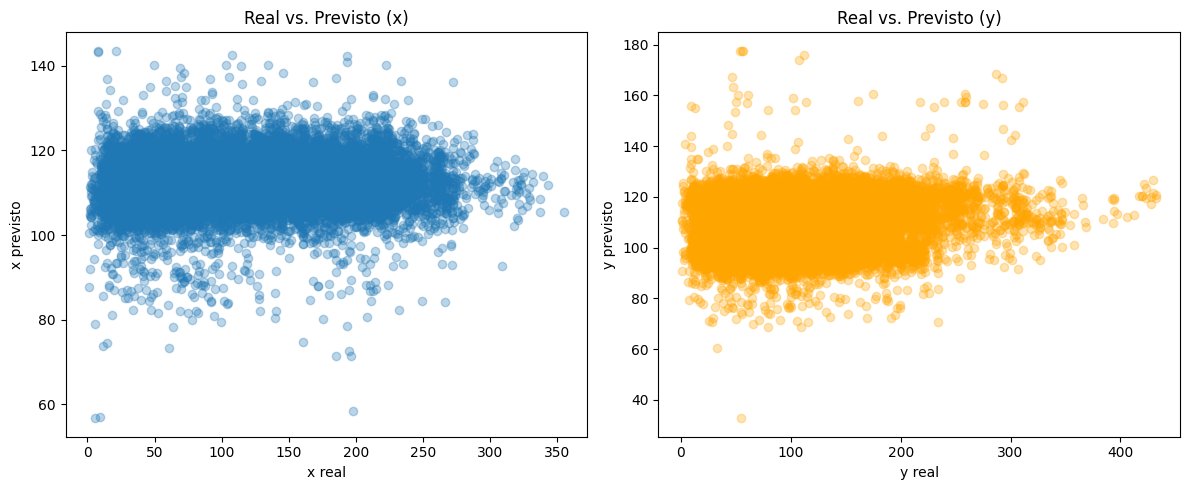

In [16]:
# Célula 8: Plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test['x'], y_pred[:,0], alpha=0.3)
plt.xlabel('x real'); plt.ylabel('x previsto')
plt.title('Real vs. Previsto (x)')

plt.subplot(1,2,2)
plt.scatter(y_test['y'], y_pred[:,1], alpha=0.3, color='orange')
plt.xlabel('y real'); plt.ylabel('y previsto')
plt.title('Real vs. Previsto (y)')

plt.tight_layout()
plt.show()


# 🎯 Célula 9: Classificação do piso (floor) e cálculo de acurácia

In [17]:
# y_floor vem do seu DataFrame y, coluna 'floor'
y_floor = y['floor']

# Usamos X_scaled (pré-processado) para balancear
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_scaled, y_floor)

print(f"Shape antes SMOTE: {X_scaled.shape}, depois SMOTE: {X_sm.shape}")


Shape antes SMOTE: (71833, 221), depois SMOTE: (157971, 221)


In [18]:
from sklearn.model_selection import train_test_split

# 1.1) Amostragem estratificada do SMOTE
X_sample, _, y_sample, _ = train_test_split(
    X_sm, y_sm,
    train_size=5000,
    stratify=y_sm,
    random_state=42
)

In [19]:
# 1.2) Rodar RandomizedSearchCV nessa amostra
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as stats

param_dist = {
    'n_neighbors': stats.randint(3, 15),
    'weights': ['uniform', 'distance']
}

rand_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_sample, y_sample)
print("🔍 Melhor KNN (amostra):", rand_search.best_params_)
print("   acc (cv) amostra:", rand_search.best_score_)

🔍 Melhor KNN (amostra): {'n_neighbors': 5, 'weights': 'distance'}
   acc (cv) amostra: 0.3614029895101412


In [20]:
# 1) SMOTE já foi aplicado e gerou X_sm, y_sm
# 2) Agora dividimos em treino/teste essas amostras balanceadas:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm,    # features balanceadas
    y_sm,    # rótulos de piso balanceados
    test_size=0.2,
    stratify=y_sm,
    random_state=42
)

print(f"Treino SMOTE: {X_train_sm.shape[0]} linhas, Teste SMOTE: {X_test_sm.shape[0]} linhas")


Treino SMOTE: 126376 linhas, Teste SMOTE: 31595 linhas


In [21]:
# 3) Avaliação final com o KNN otimizado
best_knn = rand_search.best_estimator_
best_knn.fit(X_train_sm, y_train_sm)
y_pred_full = best_knn.predict(X_test_sm)
print("✅ Acurácia final (SMOTE completo):",
      accuracy_score(y_test_sm, y_pred_full))
print(classification_report(y_test_sm, y_pred_full))


✅ Acurácia final (SMOTE completo): 0.6724798227567653
              precision    recall  f1-score   support

          -2       0.67      1.00      0.80      2872
          -1       0.59      0.57      0.58      2872
           0       0.46      0.15      0.22      2872
           1       0.35      0.07      0.12      2873
           2       0.51      0.29      0.37      2872
           3       0.55      0.52      0.54      2872
           4       0.61      0.84      0.71      2873
           5       0.65      0.97      0.78      2873
           6       0.76      0.99      0.86      2872
           7       0.89      1.00      0.94      2872
           8       0.82      1.00      0.90      2872

    accuracy                           0.67     31595
   macro avg       0.62      0.67      0.62     31595
weighted avg       0.62      0.67      0.62     31595



## Outro Modelo Acuracia

In [22]:
# 1) Preparação SMOTE
y_floor = y['floor']
X_num   = X_scaled.copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_num, y_floor)

In [23]:
# 2) Divisão treino/teste SMOTE
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm, y_sm, test_size=0.2, stratify=y_sm, random_state=42
)

In [24]:
# 3) KNN otimizado (melhor do RandomizedSearch)
best_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
best_knn.fit(X_train_sm, y_train_sm)
y_pred_knn = best_knn.predict(X_test_sm)
acc_knn = accuracy_score(y_test_sm, y_pred_knn)

print(f"✅ KNN (n_neighbors=5, weights='distance'): acc = {acc_knn:.3f}")
print(classification_report(y_test_sm, y_pred_knn))

✅ KNN (n_neighbors=5, weights='distance'): acc = 0.672
              precision    recall  f1-score   support

          -2       0.67      1.00      0.80      2872
          -1       0.59      0.57      0.58      2872
           0       0.46      0.15      0.22      2872
           1       0.35      0.07      0.12      2873
           2       0.51      0.29      0.37      2872
           3       0.55      0.52      0.54      2872
           4       0.61      0.84      0.71      2873
           5       0.65      0.97      0.78      2873
           6       0.76      0.99      0.86      2872
           7       0.89      1.00      0.94      2872
           8       0.82      1.00      0.90      2872

    accuracy                           0.67     31595
   macro avg       0.62      0.67      0.62     31595
weighted avg       0.62      0.67      0.62     31595



In [25]:
# 4) HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(max_iter=100, random_state=42)
hgb.fit(X_train_sm, y_train_sm)
y_pred_hgb = hgb.predict(X_test_sm)
acc_hgb = accuracy_score(y_test_sm, y_pred_hgb)

print(f"\n✅ HistGradientBoostingClassifier: acc = {acc_hgb:.3f}")
print(classification_report(y_test_sm, y_pred_hgb))


✅ HistGradientBoostingClassifier: acc = 0.760
              precision    recall  f1-score   support

          -2       0.90      0.98      0.93      2872
          -1       0.73      0.72      0.72      2872
           0       0.61      0.57      0.59      2872
           1       0.56      0.54      0.55      2873
           2       0.57      0.51      0.54      2872
           3       0.60      0.59      0.59      2872
           4       0.69      0.73      0.71      2873
           5       0.78      0.83      0.80      2873
           6       0.89      0.93      0.91      2872
           7       0.99      0.99      0.99      2872
           8       0.99      1.00      0.99      2872

    accuracy                           0.76     31595
   macro avg       0.75      0.76      0.76     31595
weighted avg       0.75      0.76      0.76     31595

